In [257]:
# --- 1. Import Libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [258]:
# --- 2. Configuration ---
FILE_PATH = '/Users/selim/Desktop/Projects/All In One/Hospital+Patient+Records/'

In [259]:
# --- 3. Data Loading ---
print("--- Loading Datasets ---")

try:
    # Load each dataset into specific variables as requested
    data_dictionary = pd.read_csv(FILE_PATH + 'data_dictionary.csv')
    encounters      = pd.read_csv(FILE_PATH + 'encounters.csv')
    organizations   = pd.read_csv(FILE_PATH + 'organizations.csv')
    patients        = pd.read_csv(FILE_PATH + 'patients.csv')
    payers          = pd.read_csv(FILE_PATH + 'payers.csv')
    procedures      = pd.read_csv(FILE_PATH + 'procedures.csv')

    print("All files loaded successfully.\n")

except FileNotFoundError as e:
    print(f"ERROR: Could not find one or more files at {FILE_PATH}")
    print(f"Details: {e}")
    exit()

--- Loading Datasets ---
All files loaded successfully.



In [260]:
# --- 4. Initial Data Inspection ---

# Create a list of tuples (dataframe, name) for a clean inspection loop.
# This keeps the code DRY (Don't Repeat Yourself) while preserving your variables.
datasets_to_inspect = [
    (data_dictionary, 'Data Dictionary'),
    (encounters, 'Encounters'),
    (organizations, 'Organizations'),
    (patients, 'Patients'),
    (payers, 'Payers'),
    (procedures, 'Procedures')
]

print("--- Data Structure Overview ---")

for df, name in datasets_to_inspect:
    print("=" * 50)
    print(f"Dataset: {name}")
    print("=" * 50)
    df.info()
    print("\n")

--- Data Structure Overview ---
Dataset: Data Dictionary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Table        65 non-null     object
 1   Field        60 non-null     object
 2   Description  65 non-null     object
dtypes: object(3)
memory usage: 1.7+ KB


Dataset: Encounters
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27891 entries, 0 to 27890
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   27891 non-null  object 
 1   START                27891 non-null  object 
 2   STOP                 27891 non-null  object 
 3   PATIENT              27891 non-null  object 
 4   ORGANIZATION         27891 non-null  object 
 5   PAYER                27891 non-null  object 
 6   ENCOUNTERCLASS       27891 non-null  object 
 7   CODE      

**Role:** Chief Financial Officer (CFO) & Chief Medical Officer (CMO)

**Date:** December 31, 2025

**Subject:** Q4 Hospital Operations & Financial Health Audit

---

### **Requirement #1: Insurance "Coverage Gap" Analysis**
**Business Question:**
"We are seeing an alarming increase in patient bad debt (unpaid bills). I suspect certain Insurance Payers are systematically underpaying, leaving patients with huge balances they can't afford.
Identify the top 5 Payers with the **lowest average coverage ratio**. I want to see how much we bill them (`Total_Claim_Cost`) versus how much they actually pay (`Payer_Coverage`). Focus only on Payers with at least 500 encounters to ensure statistical significance."

**Data Requirements:**
*   `encounters` table: `PAYER`, `TOTAL_CLAIM_COST`, `PAYER_COVERAGE`
*   `payers` table: `Id`, `NAME`

In [261]:
# --- 1. Data Aggregation and Metrics Calculation ---

# Group by Payer and calculate key financial metrics.
payer_stats = encounters.groupby('PAYER').agg(
    encounters_count=('Id', 'count'),
    total_billed=('TOTAL_CLAIM_COST', 'sum'),
    avg_claim_cost=('TOTAL_CLAIM_COST', 'mean'),
    avg_payment=('PAYER_COVERAGE', 'mean')
).reset_index()

# Calculate the Coverage Ratio: (What they paid / What we billed).
payer_stats['coverage_ratio'] = (payer_stats['avg_payment'] / payer_stats['avg_claim_cost'] * 100).round(2)

In [262]:
# --- 2. Filtering and Enrichment ---

# Filter 1: Statistical Significance (Minimum 500 encounters).
MIN_ENCOUNTERS = 500
payer_stats = payer_stats[payer_stats['encounters_count'] > MIN_ENCOUNTERS]

# Enrichment: Merge with the Payers table to get readable names.
payer_analysis = pd.merge(payer_stats, payers, left_on='PAYER', right_on='Id', how='left')

# Filter 2: Exclude non-insurance entities ('NO_INSURANCE', 'Private') to focus on corporate payers.
excluded_types = ['NO_INSURANCE', 'Private']
payer_analysis = payer_analysis[~payer_analysis['NAME'].isin(excluded_types)]

In [263]:
# --- 3. Identification of Worst Performers ---

# Sort by Coverage Ratio (Ascending) to find the lowest payers.
top_5_worst_payers = payer_analysis.sort_values('coverage_ratio', ascending=True).head(5).iloc[::-1].copy()

# Prepare a clean view for the table output.
display_cols = ['NAME', 'coverage_ratio', 'total_billed', 'encounters_count']

print("--- TOP 5 PAYERS WITH LOWEST COVERAGE RATIO ---")
display(top_5_worst_payers[display_cols].round(2))

--- TOP 5 PAYERS WITH LOWEST COVERAGE RATIO ---


,NAME,coverage_ratio,total_billed,encounters_count
3,UnitedHealthcare,0.15,2563507.98,900
2,Aetna,0.07,2589956.10,936
9,Humana,0.06,3543921.36,1084
0,Cigna Health,0.04,2424532.96,809
1,Anthem,0.00,2982715.05,704


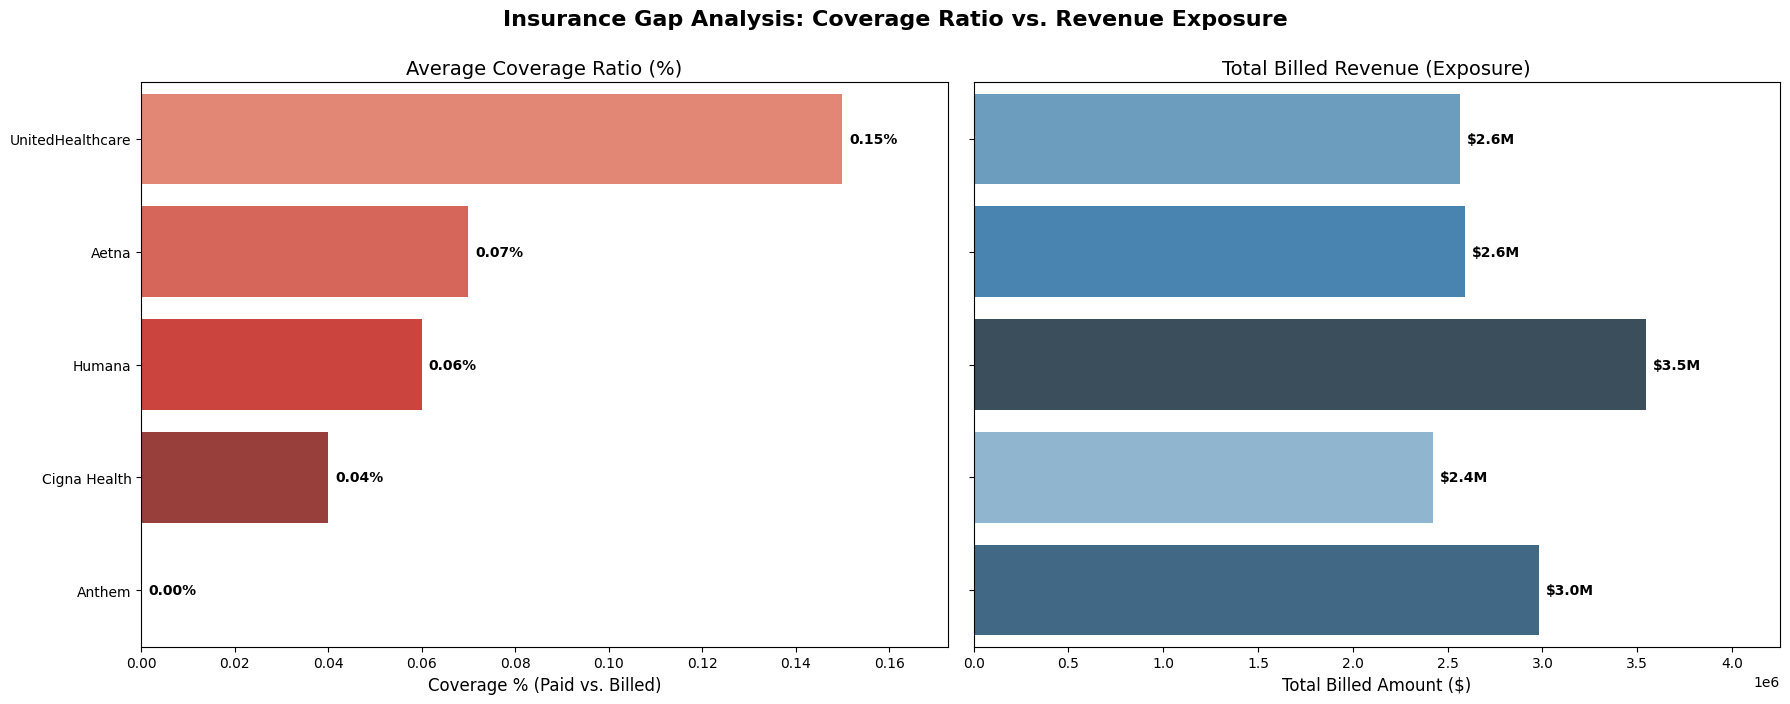

In [264]:
# --- 4. Visualization: Coverage vs. Revenue Exposure ---

# Define a formatting function for Millions ($M)
def format_millions(x):
    return f'${x / 1_000_000:.1f}M'

# Setup the figure with two side-by-side subplots sharing the Y-axis (Payer Name).
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
fig.suptitle('Insurance Gap Analysis: Coverage Ratio vs. Revenue Exposure', fontsize=16, fontweight='bold', y=1)

# Plot 1: Average Coverage Ratio (The "How Bad?" chart)
sns.barplot(
    data=top_5_worst_payers,
    y='NAME',
    x='coverage_ratio',
    hue='NAME',
    palette='Reds_d', # Red indicates a "problem" or low value
    ax=axes[0]
)

# Formatting Plot 1
axes[0].set_title('Average Coverage Ratio (%)', fontsize=14)
axes[0].set_xlabel('Coverage % (Paid vs. Billed)', fontsize=12)
axes[0].set_ylabel('')
axes[0].set_xlim(0, top_5_worst_payers['coverage_ratio'].max() * 1.15) # Add breathing room for labels


# Add value labels
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f%%', padding=5, fontweight='bold')


# Plot 2: Total Billed Amount (The "How Expensive?" chart)
# We keep the same Y-axis order as Plot 1 to allow direct row-by-row comparison.
sns.barplot(
    data=top_5_worst_payers,
    y='NAME',
    x='total_billed',
    hue='NAME',
    hue_order=top_5_worst_payers.sort_values('total_billed',ascending=True)['NAME'],
    palette='Blues_d', # Blue indicates financial volume
    ax=axes[1]
)

# Formatting Plot 2
axes[1].set_title('Total Billed Revenue (Exposure)', fontsize=14)
axes[1].set_xlabel('Total Billed Amount ($)', fontsize=12)
axes[1].set_ylabel('')
axes[1].set_xlim(0, top_5_worst_payers['total_billed'].max() * 1.2)


# Add value labels formatted in Millions
for container in axes[1].containers:
    axes[1].bar_label(container, fmt=lambda x: format_millions(x), padding=5, fontweight='bold')

plt.tight_layout()
plt.show()

---

### **Requirement #2: Procedure Profitability & Frequency**
**Business Question:**
"We are reviewing our clinical service lines for the next fiscal year. I need to know which procedures are our 'High Volume / High Cost' drivers.
Find the **Top 10 procedures** based on their *Average Base Cost*. However, exclude any niche procedures that have been performed fewer than 50 times. I need to know the procedure description and its average cost."

**Data Requirements:**
*   `procedures` table: `DESCRIPTION`, `BASE_COST`


In [265]:
# --- 1. Data Aggregation ---

# Select necessary columns.
procedure_data = procedures[['DESCRIPTION', 'BASE_COST']].copy()

# Group by Procedure Description to calculate average cost and frequency.
procedure_stats = procedure_data.groupby('DESCRIPTION').agg(
    avg_base_cost=('BASE_COST', 'mean'),
    perform_count=('BASE_COST', 'count') # Count occurrences
).reset_index()

In [266]:
# --- 2. Filtering and Ranking ---

# Business Rule: Filter for statistical significance (minimum 50 performances).
MIN_PERFORMANCES = 50
high_volume_procedures = procedure_stats[procedure_stats['perform_count'] >= MIN_PERFORMANCES].copy()

# Sort by Average Base Cost (Descending) to find the most expensive ones.
top_10_procedures = high_volume_procedures.sort_values('avg_base_cost', ascending=False).head(10)

# Round the cost for cleaner display.
top_10_procedures['avg_base_cost'] = top_10_procedures['avg_base_cost'].round(2)

In [267]:
# --- 3. Visualization Prep: Text Wrapping ---

# Helper function to wrap long labels so they don't get cut off.
def wrap_labels(label, width=35):
    return '\n'.join(textwrap.wrap(str(label), width))

# Apply wrapping to the description column.
top_10_procedures['wrapped_desc'] = top_10_procedures['DESCRIPTION'].apply(wrap_labels)

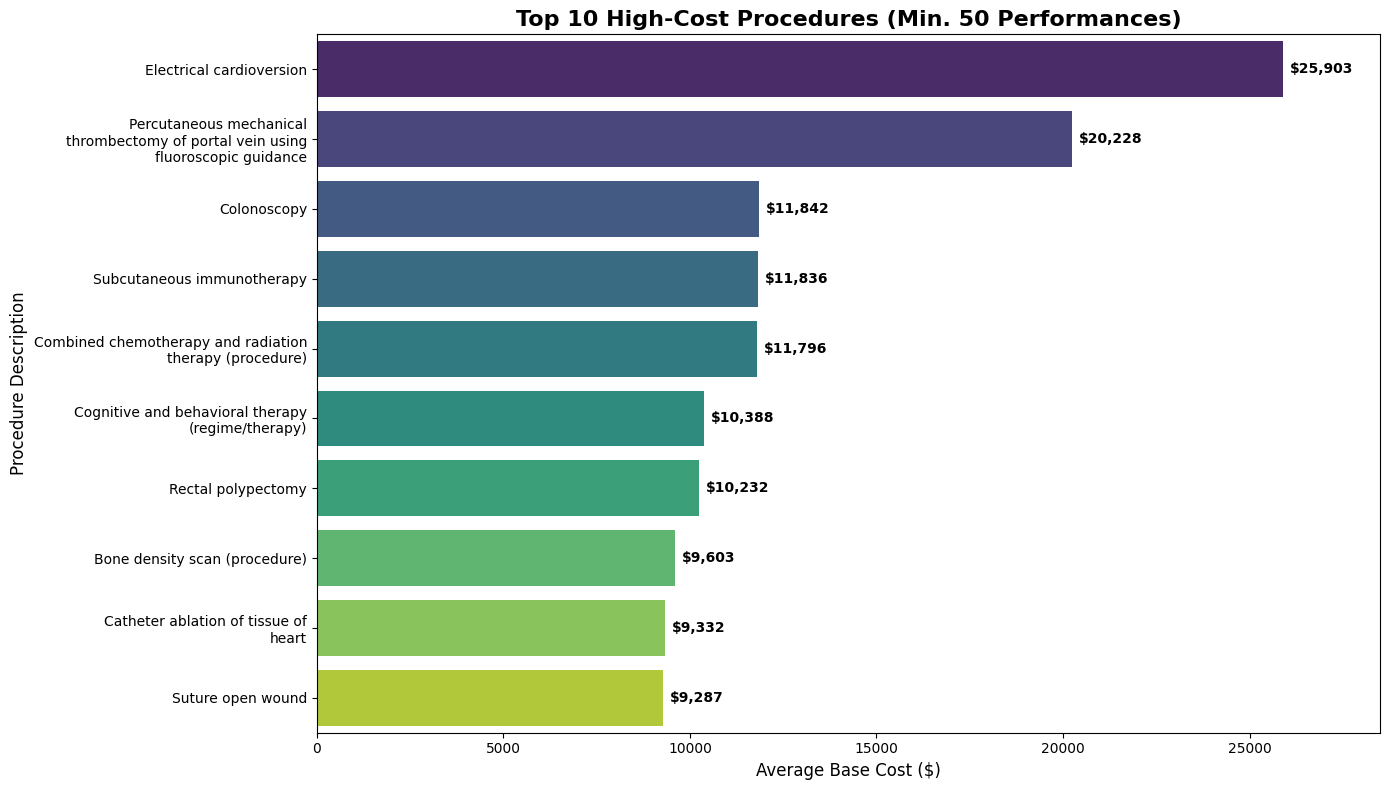

--- Top 10 High-Volume, High-Cost Procedures ---


,DESCRIPTION,avg_base_cost,perform_count
50,Electrical cardioversion,25903.11,1383
107,Percutaneous mechanical thrombectomy of portal...,20228.04,57
35,Colonoscopy,11841.99,424
143,Subcutaneous immunotherapy,11835.50,54
36,Combined chemotherapy and radiation therapy (p...,11796.39,444
34,Cognitive and behavioral therapy (regime/therapy),10388.08,136
120,Rectal polypectomy,10231.56,61
23,Bone density scan (procedure),9602.86,198
27,Catheter ablation of tissue of heart,9331.50,365
146,Suture open wound,9287.37,103


In [268]:
# --- 4. Visualization: High Cost Procedures ---

plt.figure(figsize=(14, 8))

ax = sns.barplot(
    data=top_10_procedures,
    x='avg_base_cost',
    y='wrapped_desc',
    hue='wrapped_desc',  # Used to apply the palette
    palette='viridis',   # Sequential palette implies magnitude/ranking
    legend=False         # Disable the legend as the Y-axis labels are sufficient
)

# --- Formatting ---
plt.title(f'Top 10 High-Cost Procedures (Min. {MIN_PERFORMANCES} Performances)', fontsize=16, fontweight='bold')
plt.xlabel('Average Base Cost ($)', fontsize=12)
plt.ylabel('Procedure Description', fontsize=12)

# Add numeric labels to the end of the bars.
for container in ax.containers:
    ax.bar_label(container, fmt='${:,.0f}', padding=5, fontweight='bold')

# Add extra space on the x-axis so labels fit.
plt.xlim(0, top_10_procedures['avg_base_cost'].max() * 1.1)

plt.tight_layout()
plt.show()

# --- Display Data Table ---
print("--- Top 10 High-Volume, High-Cost Procedures ---")
display(top_10_procedures[['DESCRIPTION', 'avg_base_cost', 'perform_count']])

---

### **Requirement #3: Mortality & Demographics Study**
**Business Question:**
"The Board is asking about our patient population's longevity and health equity.
Analyze the patients who have passed away (`DEATHDATE` is not null). I need two metrics for this deceased group:
1. What is the average age at death?
2. What is the breakdown of these deaths by `RACE`?
(Note: You will need to calculate Age based on BirthDate and DeathDate)."

**Data Requirements:**
*   `patients` table: `BIRTHDATE`, `DEATHDATE`, `RACE`, `Id`

In [269]:
# --- 1. Data Preparation ---

# Filter for deceased patients and create a copy to avoid warnings.
deceased_patients = patients[patients['DEATHDATE'].notna()].copy()

# Convert date columns to datetime objects (handling potential format errors).
deceased_patients['DEATHDATE'] = pd.to_datetime(deceased_patients['DEATHDATE'], errors='coerce')
deceased_patients['BIRTHDATE'] = pd.to_datetime(deceased_patients['BIRTHDATE'], errors='coerce')

# Calculate Age at Death (in years).
deceased_patients['age_at_death'] = (
    deceased_patients['DEATHDATE'] - deceased_patients['BIRTHDATE']
).dt.days / 365.25

In [270]:
# --- 2. Statistical Aggregation ---

# Calculate the Global Average.
global_avg_lifespan = deceased_patients['age_at_death'].mean()

# Group by Race to analyze volume and longevity.
mortality_stats = deceased_patients.groupby('RACE').agg(
    deaths_count=('Id', 'count'),
    avg_lifespan=('age_at_death', 'mean'),
    max_lifespan=('age_at_death', 'max'),
    min_lifespan=('age_at_death', 'min')
).reset_index().round(2)

In [271]:
# --- 3. Reporting ---

print(f"Global Average Life Expectancy: {global_avg_lifespan:.2f} Years")
print('-' * 45)
print('Detailed Mortality Breakdown by Race:')
# Sort by Average Lifespan for the table view
display(mortality_stats.sort_values('avg_lifespan', ascending=False))

Global Average Life Expectancy: 79.85 Years
---------------------------------------------
Detailed Mortality Breakdown by Race:


,RACE,deaths_count,avg_lifespan,max_lifespan,min_lifespan
2,native,3,92.91,93.31,92.62
0,asian,13,83.11,95.14,55.70
3,other,5,81.47,91.30,70.16
1,black,30,80.84,95.73,38.23
4,white,103,78.68,97.63,26.23


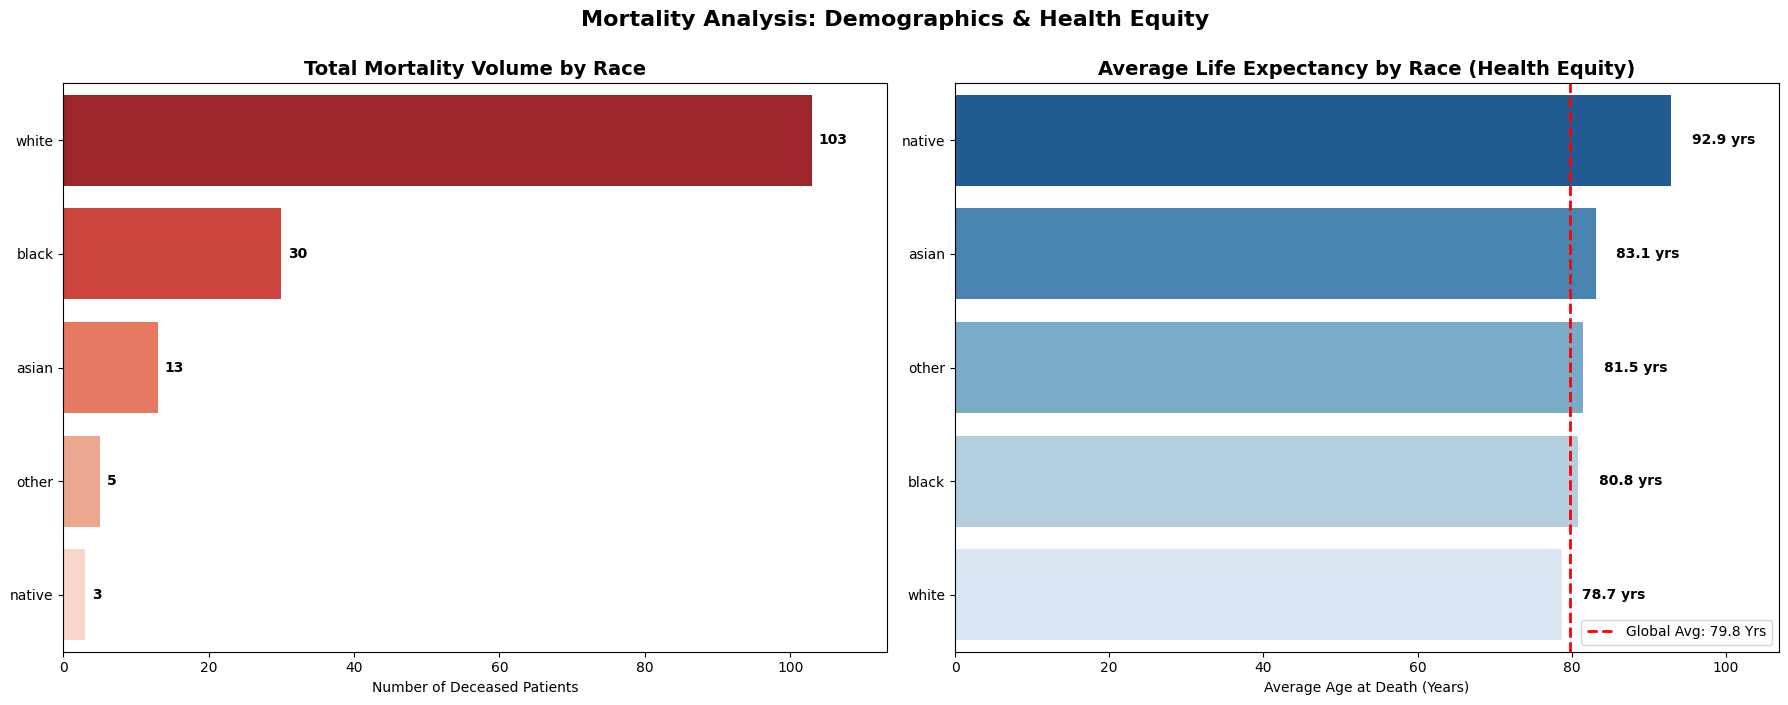

In [272]:
# --- 4. Visualization: Volume vs. Longevity ---

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Mortality Analysis: Demographics & Health Equity', fontsize=16, fontweight='bold', y=1)

# Plot 1: Total Deaths (Sorted by Volume)
# This shows WHICH group is dying most frequently.
volume_data = mortality_stats.sort_values('deaths_count', ascending=False)

sns.barplot(
    data=volume_data,
    x='deaths_count',
    y='RACE',
    hue='RACE',       # Required for palette mapping
    palette='Reds_r', # Darker red = Higher volume
    legend=False,     # Hide redundant legend
    ax=axes[0]
)

axes[0].set_title('Total Mortality Volume by Race', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Deceased Patients')
axes[0].set_ylabel('')
axes[0].set_xlim(0, volume_data['deaths_count'].max() * 1.1) # Add space for labels

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.0f', padding=5, fontweight='semibold')


# Plot 2: Average Life Expectancy (Sorted by Age)
# This shows Health Equity (who lives longest).
equity_data = mortality_stats.sort_values('avg_lifespan', ascending=False)

sns.barplot(
    data=equity_data,
    x='avg_lifespan',
    y='RACE',
    hue='RACE',
    palette='Blues_r', # Darker blue = Longer life
    legend=False,
    ax=axes[1]
)

# Add a benchmark line for the global average
axes[1].axvline(global_avg_lifespan, color='red', linestyle='--', linewidth=2, label=f'Global Avg: {global_avg_lifespan:.1f} Yrs')
axes[1].legend(loc='lower right')

axes[1].set_title('Average Life Expectancy by Race (Health Equity)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Age at Death (Years)')
axes[1].set_ylabel('')
axes[1].set_xlim(0, equity_data['avg_lifespan'].max() * 1.15)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f yrs', padding=15, fontweight='semibold')

plt.tight_layout()
plt.show()

---

### **Requirement #4: Ambulatory vs. Emergency Cost Efficiency**
**Business Question:**
"We are trying to shift traffic from our Emergency Rooms to Ambulatory (Outpatient) clinics to save costs.
Compare the `TOTAL_CLAIM_COST` between 'ambulatory' and 'emergency' encounter classes. I need to know the **Total Revenue** (Sum of Claim Cost) and the **Average Cost per Visit** for both of these specific classes side-by-side."

**Data Requirements:**
*   `encounters` table: `ENCOUNTERCLASS`, `TOTAL_CLAIM_COST`



In [273]:
# --- 1. Data Aggregation ---

# Filter for the two specific encounter classes we want to compare.
target_classes = ['ambulatory', 'emergency']
cost_efficiency_df = encounters[encounters['ENCOUNTERCLASS'].isin(target_classes)][['ENCOUNTERCLASS', 'TOTAL_CLAIM_COST']].copy()

# Group by Class to calculate Total Volume and Efficiency.
cost_stats = cost_efficiency_df.groupby('ENCOUNTERCLASS').agg(
    total_revenue=('TOTAL_CLAIM_COST', 'sum'),
    avg_cost_per_visit=('TOTAL_CLAIM_COST', 'mean')
).round(2).reset_index()

# Capitalize the class names for professional display (e.g., "emergency" -> "Emergency").
cost_stats['ENCOUNTERCLASS'] = cost_stats['ENCOUNTERCLASS'].str.title()

In [274]:
# --- 2. Reporting ---

print("--- Cost Analysis Summary ---")
display(cost_stats)

--- Cost Analysis Summary ---


,ENCOUNTERCLASS,total_revenue,avg_cost_per_visit
0,Ambulatory,36283440.84,2894.11
1,Emergency,10750051.53,4629.65


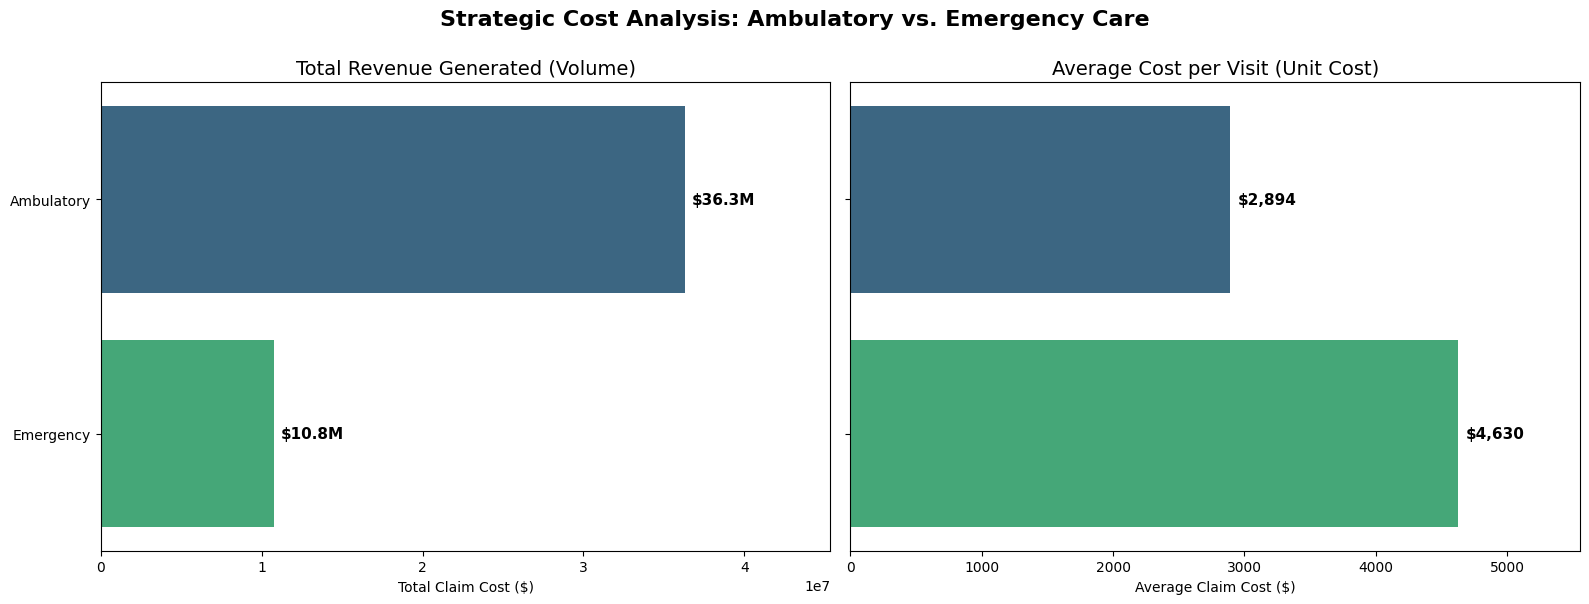

In [275]:
# --- 3. Visualization: Volume vs. Efficiency ---

# Setup: 2 Subplots.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Strategic Cost Analysis: Ambulatory vs. Emergency Care', fontsize=16, fontweight='bold', y=1)

# --- Plot 1: Total Revenue (The Financial Volume) ---
sns.barplot(
    data=cost_stats,
    x='total_revenue',
    y='ENCOUNTERCLASS',
    hue='ENCOUNTERCLASS',
    palette='viridis', # Distinct colors for contrast
    legend=False,
    ax=axes[0]
)

# Formatting Plot 1
axes[0].set_title('Total Revenue Generated (Volume)', fontsize=14)
axes[0].set_xlabel('Total Claim Cost ($)')
axes[0].set_ylabel('')
axes[0].set_xlim(0, cost_stats['total_revenue'].max() * 1.25) # Extra space for labels

# Custom label formatter for Millions
def fmt_millions(x):
    return f"${x/1_000_000:.1f}M"

for container in axes[0].containers:
    axes[0].bar_label(container, fmt=fmt_millions, padding=5, fontweight='bold', fontsize=11)


# --- Plot 2: Average Cost (The Efficiency) ---
sns.barplot(
    data=cost_stats,
    x='avg_cost_per_visit',
    y='ENCOUNTERCLASS',
    hue='ENCOUNTERCLASS',
    palette='viridis',
    legend=False,
    ax=axes[1]
)

# Formatting Plot 2
axes[1].set_title('Average Cost per Visit (Unit Cost)', fontsize=14)
axes[1].set_xlabel('Average Claim Cost ($)')
axes[1].set_ylabel('')
axes[1].set_yticklabels([]) # Hide Y-labels since they match the left chart
axes[1].set_xlim(0, cost_stats['avg_cost_per_visit'].max() * 1.2)

# Custom label formatter for standard currency
def fmt_currency(x):
    return f"${x:,.0f}"

for container in axes[1].containers:
    axes[1].bar_label(container, fmt=fmt_currency, padding=5, fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()